<a href="https://colab.research.google.com/github/robin-ochieng/time-series/blob/main/Renewals_LSTM_Vehicle_sales_forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
from sklearn.model_selection import train_test_split
from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM

In [2]:
#import/load the data 
sales_data = pd.read_excel('renewal_sales.xlsx',  index_col='Date', parse_dates = True)

In [3]:
sales_data.dtypes

Name              object
Type of Cover     object
Plate Number      object
Sales            float64
dtype: object

In [4]:
sales_data.index

DatetimeIndex(['2022-01-02 00:00:00', '2022-01-05 00:00:00',
               '2022-01-05 00:00:00', '2022-01-05 00:00:00',
               '2022-01-05 00:00:00', '2022-01-07 00:00:00',
               '2022-01-07 00:00:00', '2022-01-08 00:00:00',
               '2022-01-10 00:00:00', '2022-01-11 00:00:00',
               ...
               '2022-12-29 00:00:00', '2022-12-30 00:00:00',
               '2022-12-30 00:00:00', '2022-12-30 00:00:00',
               '2022-12-30 00:00:00', '2022-12-31 00:00:00',
               '2022-12-31 00:00:00', '2022-12-31 00:00:00',
               '2022-12-31 00:00:00', '2022-12-31 00:00:00'],
              dtype='datetime64[ns]', name='Date', length=606, freq=None)

In [5]:
sales_data

,Name,Type of Cover,Plate Number,Sales
Date,,,,
2022-01-02,ELIZABETH GONDI,COMPREHENSIVE,KAQ 910F,42153.0
2022-01-05,ALICE WANJIRU MUCHIRA,TPO,KCH 795C,2050.0
2022-01-05,MEULEDI K. MABRUKI ISEME,COMPREHENSIVE,KBY 037V,38714.0
2022-01-05,ROSELYNE ADONGO NGURE,TPO,KBE 129G,7574.0
2022-01-05,SAMUEL MWANGI MBICHO,TPO,KDA 995H,5063.0
...,...,...,...,...
2022-12-31,LUCAS NGONGA,COMPREHENSIVE,KCG786F,82337.5
2022-12-31,ANDREW MUTUMA/ ELIZABETH GAKI,COMPREHENSIVE,NaN,274731.0
2022-12-31,CHARLES ORINA MAKORI,THIRD PARTY ONLY,KBG196A,5063.0


In [7]:
new_business_sales = sales_data.iloc[:, 3]

In [ ]:
new_business_sales

Date
2022-01-01 00:00:00     7574.0
2022-01-02 00:00:00    25113.0
2022-01-02 00:19:00     7574.0
2022-01-03 00:40:00        NaN
2022-01-04 00:00:00    39718.0
                        ...   
2022-12-31 00:00:00     2063.0
2022-12-31 00:00:00     2063.0
2022-12-31 00:00:00     2063.0
2022-12-31 00:00:00     5063.0
2022-12-31 00:00:00    21527.0
Name: Sales, Length: 1018, dtype: float64

In [8]:
new_business_sales = new_business_sales.resample('D').sum()

In [9]:
new_business_sales

Date
2022-01-02     42153.00
2022-01-03         0.00
2022-01-04         0.00
2022-01-05     53401.00
2022-01-06         0.00
                ...    
2022-12-27      7574.00
2022-12-28         0.00
2022-12-29     41727.00
2022-12-30    184948.75
2022-12-31    372257.50
Freq: D, Name: Sales, Length: 364, dtype: float64

In [10]:
daily_nonzero_sales =  new_business_sales[new_business_sales != 0]
print(daily_nonzero_sales)

Date
2022-01-02     42153.00
2022-01-05     53401.00
2022-01-07     64785.00
2022-01-08      7574.00
2022-01-10     83162.00
                ...    
2022-12-23    121986.25
2022-12-27      7574.00
2022-12-29     41727.00
2022-12-30    184948.75
2022-12-31    372257.50
Name: Sales, Length: 275, dtype: float64


In [11]:
daily_nonzero_sales.describe()

count       275.000000
mean      73044.824807
std       86404.604212
min        2000.000000
25%       10126.000000
50%       42812.250000
75%       99174.500000
max      592432.750000
Name: Sales, dtype: float64

/usr/local/lib/python3.9/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


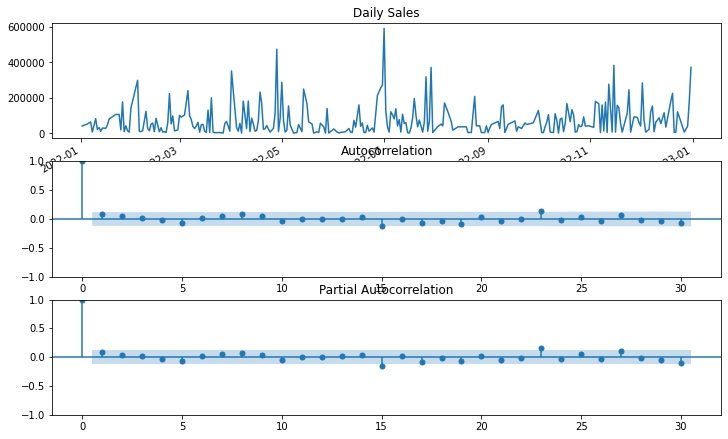

In [12]:
# Determine seasonality, outliers, and trend
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(12, 8))
daily_nonzero_sales.plot(ax=axes[0], title='Daily Sales')
sm.graphics.tsa.plot_acf(daily_nonzero_sales, lags=30, ax=axes[1])
sm.graphics.tsa.plot_pacf(daily_nonzero_sales, lags=30, ax=axes[2])
plt.show()

<Axes: title={'center': 'Daily Sales Renewals'}, xlabel='Date'>

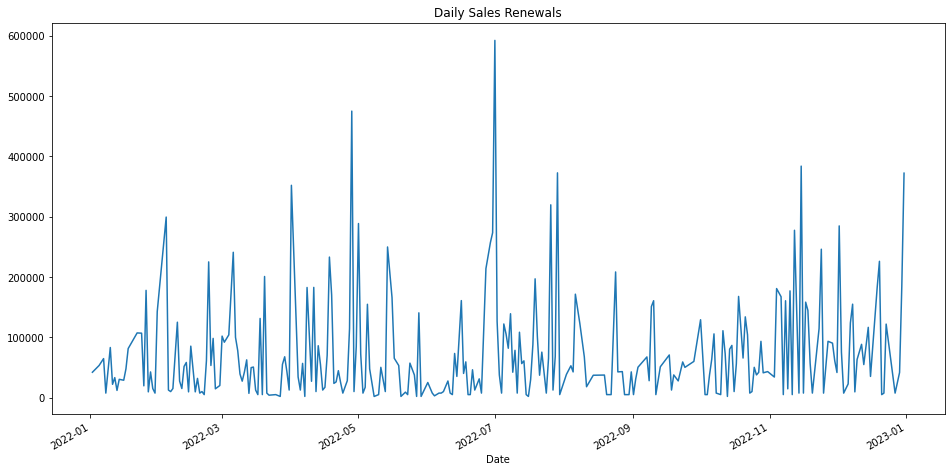

In [13]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(16, 8))
daily_nonzero_sales.plot(title='Daily Sales Renewals')
 

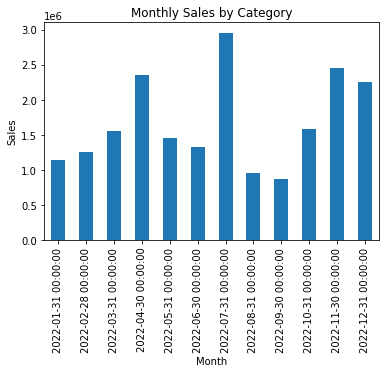

In [14]:
#Bar chart of monthly sales by category
monthly_sales = new_business_sales.resample('M').sum()

# Create a bar chart of monthly sales by category
monthly_sales.plot(kind='bar')
plt.title('Monthly Sales by Category')
plt.xlabel('Month')
plt.ylabel('Sales')
plt.show()

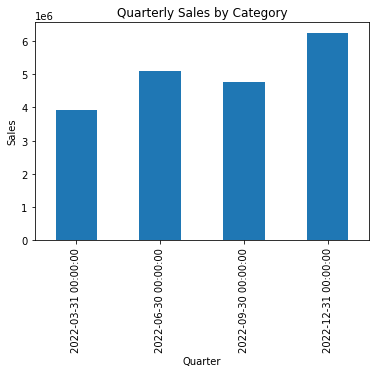

In [15]:
#Bar chart of monthly sales by category
quarterly_sales = new_business_sales.resample('Q').sum()

# Create a bar chart of monthly sales by category
quarterly_sales.plot(kind='bar')
plt.title('Quarterly Sales by Category')
plt.xlabel('Quarter')
plt.ylabel('Sales')
plt.show()

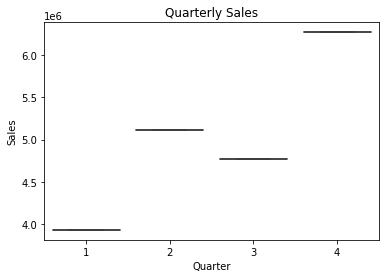

In [16]:
# Plot the quarterly sales data as a box plot
sns.boxplot(x=quarterly_sales.index.quarter, y=quarterly_sales)
plt.title('Quarterly Sales')
plt.xlabel('Quarter')
plt.ylabel('Sales')
plt.show()

In [17]:
daily_nonzero_sales = daily_nonzero_sales.asfreq('d')
sales = daily_nonzero_sales.fillna(0, inplace=True)

In [18]:
#Decomposing the time series into its seasonal, trend, and residual components.
decomposition = sm.tsa.seasonal_decompose(daily_nonzero_sales, model='additive')

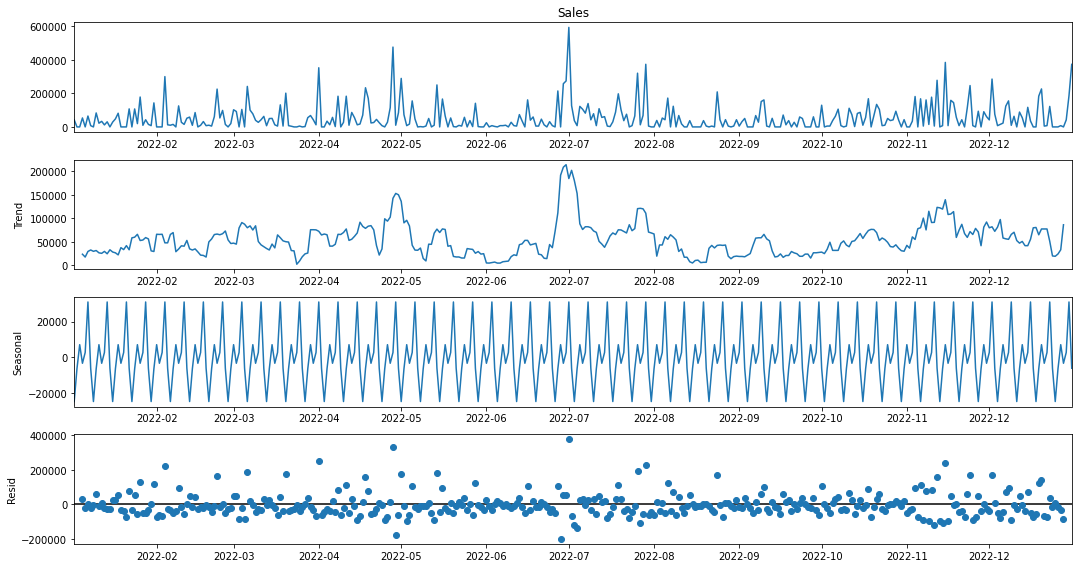

In [20]:
fig = decomposition.plot()
fig.set_size_inches((15, 8))
fig.tight_layout()
plt.show()

In [21]:
vehicle_sales_2022 =  daily_nonzero_sales[daily_nonzero_sales != 0]
print(vehicle_sales_2022)

Date
2022-01-02     42153.00
2022-01-05     53401.00
2022-01-07     64785.00
2022-01-08      7574.00
2022-01-10     83162.00
                ...    
2022-12-23    121986.25
2022-12-27      7574.00
2022-12-29     41727.00
2022-12-30    184948.75
2022-12-31    372257.50
Name: Sales, Length: 275, dtype: float64


In [22]:
vehicle_sales_2022.loc[vehicle_sales_2022.idxmin()]

2000.0

In [23]:
vehicle_sales_2022.loc[vehicle_sales_2022.idxmax()]

592432.75

In [24]:
vehicle_sales_2022.info()

<class 'pandas.core.series.Series'>
DatetimeIndex: 275 entries, 2022-01-02 to 2022-12-31
Series name: Sales
Non-Null Count  Dtype  
--------------  -----  
275 non-null    float64
dtypes: float64(1)
memory usage: 12.4 KB


<Axes: xlabel='y(t)', ylabel='y(t + 1)'>

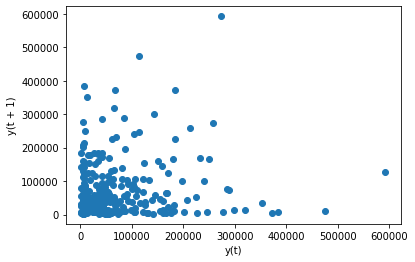

In [25]:
from pandas.plotting import lag_plot
lag_plot(vehicle_sales_2022)

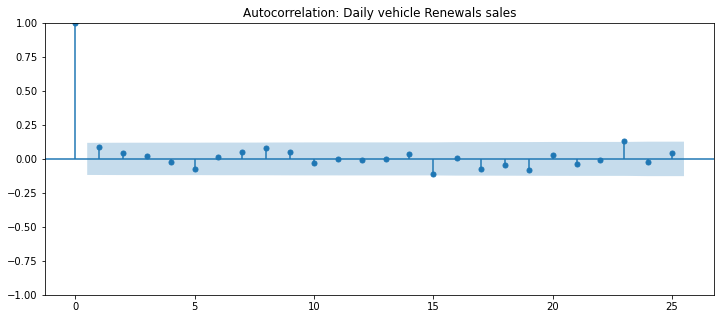

In [27]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acovf,acf,pacf,pacf_yw,pacf_ols
fig, ax = plt.subplots(figsize=(12,5))
title = "Autocorrelation: Daily vehicle Renewals sales"
lags = 25
plot_acf(vehicle_sales_2022, title = title, lags = lags,ax=ax);

/usr/local/lib/python3.9/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


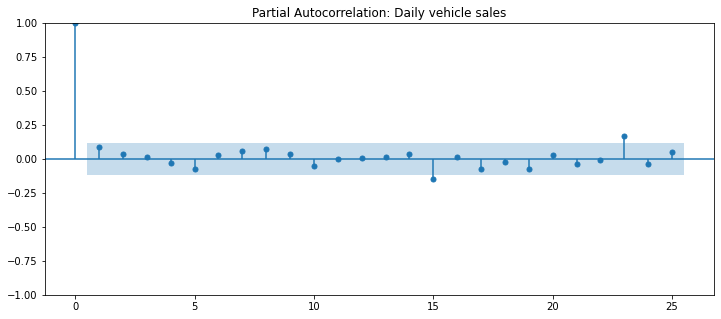

In [28]:
fig, ax = plt.subplots(figsize=(12,5))
title1 = "Partial Autocorrelation: Daily vehicle sales"
lags =25
plot_pacf(vehicle_sales_2022, title = title1, lags = lags,ax=ax);

In [29]:
#test for stationarity using ADF test
from statsmodels.tsa.stattools import adfuller
values = vehicle_sales_2022.values
adf_fuller = adfuller(values)
print(f'Augmneted Dickey_fuller Statistic: {adf_fuller[0]}')
print(f'p-value: {adf_fuller[1]}')
#we have a very high p-value at 1.4423, which provides weak evidence against the null hypothesis, and so we fail to reject the null hypothesis, and decide that our dataset is not stationary, meaning the time series data is non-stationary.

Augmneted Dickey_fuller Statistic: -14.7503035700441
p-value: 2.4910095022833497e-27


Epoch 1/100
6/6 - 2s - loss: 0.0337 - val_loss: 0.0307 - 2s/epoch - 391ms/step
Epoch 2/100
6/6 - 0s - loss: 0.0244 - val_loss: 0.0256 - 77ms/epoch - 13ms/step
Epoch 3/100
6/6 - 0s - loss: 0.0258 - val_loss: 0.0257 - 78ms/epoch - 13ms/step
Epoch 4/100
6/6 - 0s - loss: 0.0250 - val_loss: 0.0261 - 77ms/epoch - 13ms/step
Epoch 5/100
6/6 - 0s - loss: 0.0242 - val_loss: 0.0269 - 81ms/epoch - 13ms/step
Epoch 6/100
6/6 - 0s - loss: 0.0241 - val_loss: 0.0269 - 85ms/epoch - 14ms/step
Epoch 7/100
6/6 - 0s - loss: 0.0240 - val_loss: 0.0264 - 81ms/epoch - 14ms/step
Epoch 8/100
6/6 - 0s - loss: 0.0241 - val_loss: 0.0261 - 96ms/epoch - 16ms/step
Epoch 9/100
6/6 - 0s - loss: 0.0241 - val_loss: 0.0261 - 83ms/epoch - 14ms/step
Epoch 10/100
6/6 - 0s - loss: 0.0241 - val_loss: 0.0263 - 76ms/epoch - 13ms/step
Epoch 11/100
6/6 - 0s - loss: 0.0240 - val_loss: 0.0265 - 78ms/epoch - 13ms/step
Epoch 12/100
6/6 - 0s - loss: 0.0239 - val_loss: 0.0265 - 80ms/epoch - 13ms/step
Epoch 13/100
6/6 - 0s - loss: 0.0239 -

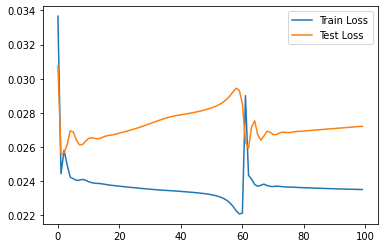

2/2 [==============================] - 0s 7ms/step


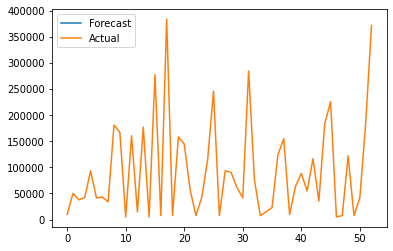

In [31]:

# extract the sales values and normalize them using MinMaxScaler
sales_values = vehicle_sales_2022.values.reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_sales = scaler.fit_transform(sales_values)

# split the data into a training set and a testing set with a 70/30 split
train_size = int(len(scaled_sales) * 0.7)
test_size = len(scaled_sales) - train_size
train_data, test_data = scaled_sales[0:train_size,:], scaled_sales[train_size:len(scaled_sales),:]

# define a function to create time steps for LSTM input
def create_time_steps(length):
    return list(range(-length, 0))

# define a function to create LSTM input data
def create_lstm_input(sales_data, window_size):
    X, Y = [], []
    for i in range(len(sales_data)-window_size):
        X.append(sales_data[i:i+window_size, 0])
        Y.append(sales_data[i+window_size, 0])
    return np.array(X), np.array(Y)

# define the window size for LSTM input
window_size = 30

# create LSTM input data for training and testing
train_X, train_Y = create_lstm_input(train_data, window_size)
test_X, test_Y = create_lstm_input(test_data, window_size)

# reshape the LSTM input data to fit the expected input shape for the LSTM model
train_X = np.reshape(train_X, (train_X.shape[0], train_X.shape[1], 1))
test_X = np.reshape(test_X, (test_X.shape[0], test_X.shape[1], 1))

# define the LSTM model architecture
model = Sequential()
model.add(LSTM(50, input_shape=(window_size, 1)))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='adam')

# train the model
history = model.fit(train_X, train_Y, epochs=100, batch_size=32, validation_data=(test_X, test_Y), verbose=2, shuffle=False)

# plot the loss over time during training
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.legend()
plt.show()

# use the trained model to make predictions on the test data
predictions = model.predict(test_X)

# invert the scaling on the predictions and the actual values
predictions = scaler.inverse_transform(predictions)
actual_values = scaler.inverse_transform([test_Y])

# plot the forecasted and actual values
plt.plot(predictions[0], label='Forecast')
plt.plot(actual_values[0], label='Actual')
plt.legend()
plt.show()

In [32]:
predictions

array([[ 70191.57 ],
       [ 66508.055],
       [ 68912.64 ],
       [ 69126.484],
       [ 69980.35 ],
       [ 75304.13 ],
       [ 72791.03 ],
       [ 72043.39 ],
       [ 70946.164],
       [ 84003.055],
       [ 87503.82 ],
       [ 73602.234],
       [ 81794.09 ],
       [ 71449.   ],
       [ 81943.62 ],
       [ 70381.55 ],
       [ 90360.266],
       [ 73360.375],
       [100347.055],
       [ 75806.055],
       [ 79564.92 ],
       [ 79193.66 ],
       [ 71404.51 ],
       [ 64357.16 ],
       [ 65179.12 ],
       [ 72527.32 ],
       [ 87635.91 ],
       [ 72226.55 ],
       [ 73889.5  ],
       [ 74195.1  ],
       [ 71988.22 ],
       [ 69654.86 ],
       [ 90770.88 ],
       [ 79716.914],
       [ 69460.36 ],
       [ 66027.67 ],
       [ 65716.54 ],
       [ 75211.48 ],
       [ 82113.8  ],
       [ 71758.99 ],
       [ 72480.78 ],
       [ 75046.81 ],
       [ 73136.96 ],
       [ 78044.33 ],
       [ 72583.586],
       [ 83815.73 ],
       [ 91539.31 ],
       [ 7415

In [33]:
actual_values

array([[ 10126.   ,  50306.   ,  37709.   ,  42018.875,  93418.5  ,
         41225.   ,  43234.   ,  34233.25 , 180930.   , 167370.   ,
          5063.   , 160709.7  ,  14648.   , 177083.125,   5063.   ,
        277573.25 ,   7574.   , 383945.61 ,   7574.   , 158369.   ,
        144688.5  ,  57297.   ,   7574.   ,  42691.25 , 114672.5  ,
        246182.5  ,   7547.   ,  93418.5  ,  90445.   ,  61355.   ,
         41747.   , 284815.75 ,  75418.   ,   7533.75 ,  15067.5  ,
         22763.   , 123894.   , 155024.25 ,   9596.75 ,  63324.   ,
         88436.   ,  54886.25 , 116615.75 ,  35238.   , 183311.53 ,
        226122.75 ,   5022.5  ,   7533.75 , 121986.25 ,   7574.   ,
         41727.   , 184948.75 , 372257.5  ]])